In [1]:
import ipywidgets as wg
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import igraph
import copy

from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image

from jie.demo import mock_experiment, error_types, polymer_model, polymer_skip, find_polymer

from jie.aligner import (log_bond,
                         find_chr,
                         edge_weights,
                         boundary_init)

from jie.utilities import (cartesian_esqsum, 
                           cartesian_sqdiff, 
                           cartesian_diff, 
                           check_lp_wgaps,
                           find_loci_dist)

## Demo
- Say we put a haploid cell under the microscope, and perform multiplexed DNA-FISH
    - Within one nucleus, we image 4 genes each separated by `5 kb`, all lying on the same chromosome
    - We excite each labeled gene sequentially, quenching its signal before imaging the next gene:

In [2]:
wg.interact(mock_experiment, Slides=wg.IntSlider(min=1,max=6,step=1, description="Slides : {} /".format(6)));

interactive(children=(IntSlider(value=1, description='Slides : 6 /', max=6, min=1), Output()), _dom_classes=('…

- `5kb` in the scope of the entire genome is fairly small. We'd expect the spatial coordinates of genes lying on the same contiguous fiber to be spatially proximal.
    - Yet, we see multiple spots for every gene (in a haploid genome, where we'd expect to see `n=1` spot per locus) and they appear all over the place. What's happening here?
---
- We might be tempted to find __the closest series of spots__ belonging to each locus. Here's why this is a __pitfall__:
    - What we think might be happening is a collection of errors that disguise detection of the true loci belonging to the contiguous chromatin fiber:
        - The true chromatin fiber `DNA (unobserved)` is not imaged.
        - Instead, we intend to discern discrete locations `True Pos (Ground Truth); Red cross` with FISH probes, to gain a coarse-grain view of chromatin structure.
        - In practice, the signal emitted from these FISH probes (`True Pos (Observed) ; Green circles`) may be displaced from its true location.
        - Some signals may not emit at all, as FISH probes fail to label an intended locus (`False Neg ; Yellow triangles`)
        - Still other signals (ie. off-target hybridization, background fluorescence, hot-pixels) have high signal intensity and may be mistaken as a real signal (`False Pos; Purple diamonds`)


In [3]:
wg.interact(error_types, Slides=wg.IntSlider(min=1,max=6,step=1, description="Slides : {} /".format(6)));

interactive(children=(IntSlider(value=1, description='Slides : 6 /', max=6, min=1), Output()), _dom_classes=('…

---
##### Load example data

- To figure out which spots belong the true chromatin fiber, we can perform a type of inference.
    - We load the data from our mock experiment:

In [4]:
# load data
df = pd.read_csv("../data/df_spalign_demo.csv")
df.columns = ['x_hat', 'y_hat', 'z_hat', 'Annot', 't', 'bp']
df.reset_index(drop = True, inplace = True)

# subset data
df_fiber = df[df['Annot'] == 'Fiber']
df_data = df[(df['Annot'] != 'Fiber') & (df['Annot'] != 'FN')].sort_values(by='t')

# add indexing
df_list = []
for hyb, group in df_data.groupby(by='t'):
    _df = copy.deepcopy(group)
    _df['i'] = list(range(_df.shape[0]))
    df_list.append(_df)
df_data = pd.concat(df_list)

df_data = df_data[['x_hat', 'y_hat', 'z_hat', 'Annot', 't', 'i', 'bp']]
    
# add localization err
df_data['sig_x'] = 1
df_data['sig_y'] = 1
df_data['sig_z'] = 1  

# make all positions positive
df_data['x_hat'] = df_data['x_hat'].values - np.min(df_data['x_hat'].values)
df_data['y_hat'] = df_data['y_hat'].values - np.min(df_data['y_hat'].values)
df_data['z_hat'] = df_data['z_hat'].values - np.min(df_data['z_hat'].values)

In [5]:
df_data

,x_hat,y_hat,z_hat,Annot,t,i,bp,sig_x,sig_y,sig_z
0,7.121910,7.182445,6.081194,TP,0,0,0,1,1,1
15001,8.508098,9.697731,9.965565,FP,0,1,0,1,1,1
15002,10.631071,7.161015,9.452167,FP,0,2,0,1,1,1
5000,8.345561,8.037631,5.236670,TP,1,0,5000,1,1,1
15003,12.077955,9.836819,8.411960,FP,1,1,5000,1,1,1
15004,8.011521,5.150124,2.489517,FP,1,2,5000,1,1,1
15005,0.000000,0.000000,1.237000,FP,2,0,10000,1,1,1
15006,0.511619,0.446863,0.000000,FP,2,1,10000,1,1,1
15000,5.277496,6.326657,5.903535,TP,3,0,15000,1,1,1
15007,6.239161,4.478541,3.684852,FP,3,1,15000,1,1,1


- Above, we have a series of `4-D` spatial coordinates, acquired by sequentially imaging 4 loci inside one nucleus. 
    - We know the coordinates in Euclidean space (`x_hat`, `y_hat`, `z_hat`).
    - We also know the order of these loci (`t`).and the genomic distance relative to the first locus imaged (`bp`)
        - __Q__: When discrete genes are imaged and __the fiber connecting them is not visualized__, how can we __infer__ which signals lie on the __same contiguous chromatin fiber__?

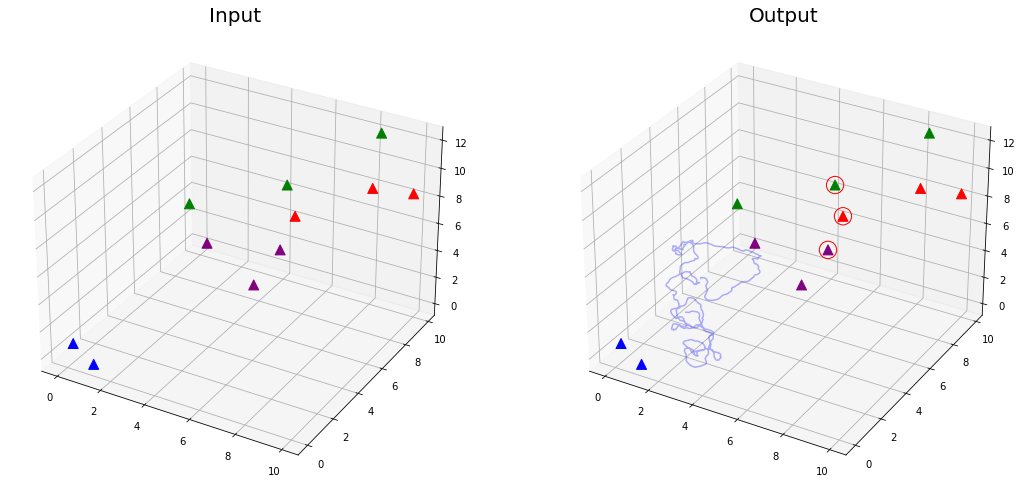

In [6]:
# plot
fig = plt.figure(figsize = (18, 9))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

# Draw imaged loci
cdict = {0:'Red', 1:'Green', 2:'Blue', 3:'Purple'}
ax1.scatter(df_data.loc[:, 'z_hat'],
           df_data.loc[:, 'y_hat'],
           df_data.loc[:, 'x_hat'],
           c=[cdict[elem] for elem in df_data.t], alpha = 1, marker='^', s = 100)

ax1.set_title("Input", fontsize = 20);

# Draw imaged loci
cdict = {0:'Red', 1:'Green', 2:'Blue', 3:'Purple'}
ax2.scatter(df_data.loc[:, 'z_hat'],
           df_data.loc[:, 'y_hat'],
           df_data.loc[:, 'x_hat'],
           c=[cdict[elem] for elem in df_data.t], alpha = 1, marker='^', s = 100)

# Draw fiber
ax2.plot(df_fiber.loc[:, 'z_hat'], df_fiber.loc[:, 'y_hat'], df_fiber.loc[:, 'x_hat'], c='Blue', alpha = 0.3, label = 'DNA (unobserved)')

# Draw true positive (true location)
ax2.scatter(df_data.loc[[0, 5000, 15000], 'z_hat'],
            df_data.loc[[0, 5000, 15000], 'y_hat'],
            df_data.loc[[0, 5000, 15000], 'x_hat'],
            alpha = 1, marker='o', s = 300, facecolors='none', edgecolors='r')

ax2.set_title("Output", fontsize = 20);

---
##### The key insight here is recognizing that true loci lie on the same contiguous fiber and are physically linked.
---
- What if we can examine the probability two loci are connected?
    - Take the first locus `t = 0; Red` and second locus `t = 1; Green` for example. 
    - If we didn't have the annotation (provided for this dummy example), it's hard to tell which of the three spots belonging to first locus (`t = 0`; `Red`) is connected to which of the three spots belonging to the second locus (`t = 1`; `Green`)

In [7]:
df_data[df_data['t'] <= 1]

,x_hat,y_hat,z_hat,Annot,t,i,bp,sig_x,sig_y,sig_z
0,7.121910,7.182445,6.081194,TP,0,0,0,1,1,1
15001,8.508098,9.697731,9.965565,FP,0,1,0,1,1,1
15002,10.631071,7.161015,9.452167,FP,0,2,0,1,1,1
5000,8.345561,8.037631,5.236670,TP,1,0,5000,1,1,1
15003,12.077955,9.836819,8.411960,FP,1,1,5000,1,1,1
15004,8.011521,5.150124,2.489517,FP,1,2,5000,1,1,1


---
- If we use a __polymer model__ to draw bonds between these candidate spots, we might be able to figure out which pair is most probably physically linked.
<br></br>
- Say we draw a polymer bond between `t=0; i=0 (True Positive)` --> `t=1; i=1 (False Positive)`. 
- We also draw a polymer bond between `t=0; i=0 (True Positive)` --> `t=1; i=0 (True Positive)`
<br></br>
    - We evaluate the bond probability using the following formula:
$$
w_{t ; i}^{t+c ; j}=\frac{1}{\left(2 \pi\left(s^{t+c;j}_{t;i}\right)^{2}\right)^{3 / 2}} e^{-\frac{(R_{t ; i}^{t+c_{j} ; j})^{2}}{2(s_{t ; i}^{t+c ; j})^{2}}}
$$
<br></br>
- $R_{t;i}^{t+c;j}$ is the Euclidean distance, or observed spatial distance, between two imaged loci.
- $s^{t+c;j}_{t;i}$ is a function of the expected polymer contour length:

$$
\frac{2}{3}l_{p}\tau L^{t+c;j}_{t;i}
$$
<br></br>
- $l_{p}$ is the persistence length of DNA. We fix this as `150bp`, a value derived from studying DNA in free solution (the true persistence length _in situ_ is likely different)
- $\tau$ is the distance parameter that converts base pairs to nanometers. We fix this as `0.34nm/bp`; the lengthscale of DNA _in situ_ is also likely different.
- $L^{t+c;j}_{t;i}$ is the genomic distance separating locus `t;i` and locus `t+c;j`
    - The length of the expected distance is based on the genomic separation between these two spots, `5000 bp`. 

In [4]:
wg.interact(polymer_model, Slides=wg.IntSlider(min=1,max=6,step=1, description="Slides : {} /".format(6)));

interactive(children=(IntSlider(value=1, description='Slides : 6 /', max=6, min=1), Output()), _dom_classes=('…

---
Note: we take the **negative log bond probability below**.

In [9]:
# parms
nm_per_bp = 0.34
pixel_dist = 100
l_p_bp = 150
l_p = l_p_bp*nm_per_bp/pixel_dist
L = 5000

# calculate expected contour length
s = L*nm_per_bp/pixel_dist

# calculate Euclidean distance between observed spots
r_fp = np.linalg.norm(df_data.iloc[0, :3]- df_data.iloc[4, :3])
r_tp = np.linalg.norm(df_data.iloc[0, :3]- df_data.iloc[3, :3])

print("This is the bond probability between spot 1, hyb 0 - spot 1, hyb 1: ", 
      log_bond(l_p, s, r_fp))

print("This is the bond probability between spot 1, hyb 0 - spot 2, hyb 1: ",
      log_bond(l_p, s, r_tp))

This is the bond probability between spot 1, hyb 0 - spot 1, hyb 1:  8.592620998568247
This is the bond probability between spot 1, hyb 0 - spot 2, hyb 1:  5.642909529063303


- We see that the bond probability (negative log probability) is less probable (greater negative log probability) for `t=0; i=0 (True Positive) --> t=1; i=1 (False Positive)`, than for `t=0; i=0 (True Positive) --> t=1; i=0 (True Positive)`
    - In this manner, we can evaluate the probability two discrete signals are linked on the same polymer fiber using this function.
    
---
- It turns out the multiplicative product of each of these bond probabilities, spanning from beginning to end of a chromatin fiber, reflects its __physical likelihood__ (Conformational Distribution Function; CDF):

$$
C D F=\prod_{h=1}^{H} w_{v_{h}}^{v_{h+1}}, p=\left\langle v_{1}, v_{2} \ldots v_{H}\right\rangle
$$

- We strive to seek the series of bond probabilities that allow us to connect the start of the chromatin to the end, such that we can __maximize__ the bond probabilities between every pair of imaged locus.
    - If we use negative log probabilities:
$$
w' = ln(w)
$$
    - ...this is reframed as the __sum__ of negative log probabilities, and a value we strive to __minimize__:
    
$$
CDF^{*} = \min \sum_{h=1}^{H} w_{v_{h}}^{'v_{h+1}}, p^{*}=\left\langle v_{1}, v_{2} \ldots v_{H}\right\rangle
$$

where $p^{*}$ is the series of most optimal bonds (shortest path).

#### Spatial genome alignment

- Let's apply spatial genome alignment to this demo dataset. What's the most likely fiber we find among these spatial locations?

In [10]:
cell_pts_input = copy.deepcopy(df_data)
cell_pts_input.rename(columns = {'t':'hyb'}, inplace = True)

mat, path, _ = find_chr(cell_pts_input = cell_pts_input, 
                        gene_dist = [0, 5000, 10000, 15000], 
                        bin_size = 5000,
                        nm_per_bp = 0.34,
                        num_skip = 3,
                        total_num_skip_frac = 1,
                        norm_skip_penalty = False,
                        stretch_factor = 1.01,
                        init_skip_frac = 0,
                        lim_init_skip = False,
                        lim_min_dist=False)

df_data.iloc[path]

/home/b2jia/projects/jie/jie/aligner.py:563: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  pts_clr_next = cell_pts.loc[cell_pts['hyb'].between(i, i+num_skip, inclusive = False)]


,x_hat,y_hat,z_hat,Annot,t,i,bp,sig_x,sig_y,sig_z
0,7.121910,7.182445,6.081194,TP,0,0,0,1,1,1
5000,8.345561,8.037631,5.236670,TP,1,0,5000,1,1,1
15000,5.277496,6.326657,5.903535,TP,3,0,15000,1,1,1


- It looks like the most likely fiber is one that traverses `t=0`, `t=1` and `t=3` loci, as any connection to `t=2; (Blue)` is deemed physically unlikely
    - What's happening behind the scenes of this function, `jie.aligner.find_chr`?

---
##### Under the hood

In [11]:
cell_pts_input = copy.deepcopy(df_data)
cell_pts_input.rename(columns={'t':'hyb'}, inplace = True)
gene_dist = [0, 5000, 10000, 15000]
bin_size = 5000
nm_per_bp = 0.34
num_skip = 3
stretch_factor=1.2
exp_stretch = 1
total_num_skip_frac = 1
norm_skip_penalty = False
stretch_factor = 1.01
init_skip_frac = 0
theta = np.pi/20
lim_init_skip = False
lim_min_dist=False

############################################

## Define constants ##
n_colours = len(gene_dist)
init_skip = int(init_skip_frac*n_colours)
end_skip = int((1-init_skip_frac)*n_colours)-1
total_num_skip = int(total_num_skip_frac*len(gene_dist)) 
corr_fac = nm_per_bp / pixel_dist
l_p = l_p_bp * nm_per_bp / pixel_dist # persistence length in pixels

loci_dist = find_loci_dist(gene_dist = gene_dist,
                           nm_per_bp = nm_per_bp,
                           pixel_dist = pixel_dist)

# make copy of input dataframe
cell_pts = copy.deepcopy(cell_pts_input)

# add current index
cell_pts.reset_index(inplace=True, drop = True)
cell_pts['CurrIndex'] = cell_pts.index

# create transition matrix
n_states =  cell_pts.shape[0]  
trans_mat = np.zeros((n_states, n_states))

trans_mat_prog = {}
trans_mat_prog[-1] = copy.deepcopy(trans_mat)

for i in set(cell_pts['hyb']):
    
    # grab nodes of curr hyb and reachable hyb
    pts_clr_curr = cell_pts.loc[cell_pts['hyb']==i]
    pts_clr_next = cell_pts.loc[cell_pts['hyb'].between(i, i+num_skip, inclusive = False)]

    # grab node indeces in adjacency matrix
    ## NB: rows --> starting vertices | cols --> ending vertices
    rows = pts_clr_curr['CurrIndex'].values
    cols = pts_clr_next['CurrIndex'].values

    # convert node indeces to position in transition matrix
    trans_idx = (np.array([n_states*rows, ] * len(cols)).T + np.array(cols)).flatten().astype(int)

    # find degrees of separation between nodes
    next_hyb = i+1
    skips = np.array([pts_clr_next['hyb'].values,] * pts_clr_curr.shape[0] ) - np.min([next_hyb, n_colours-1])

    # calculate edge weights
    trans_prob = edge_weights(pts_clr_curr, pts_clr_next, 
                              bin_size, l_p_bp, 
                              nm_per_bp, pixel_dist, 
                              theta, loci_dist, lim_min_dist)

    # update transition matrix
    np.put(trans_mat, trans_idx, trans_prob)
    
    # save state
    trans_mat_prog[i] = copy.deepcopy(trans_mat)
    
    # save intermediate data
    if i == 0:
        ex_pts_clr_curr = copy.deepcopy(pts_clr_curr)
        ex_pts_clr_next = copy.deepcopy(pts_clr_next)
        ex_trans_prob = copy.deepcopy(trans_prob)
    if i == 1:
        ex_trans_prob_skip = copy.deepcopy(trans_prob)

/tmp/ipykernel_18703/1976230745.py:49: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  pts_clr_next = cell_pts.loc[cell_pts['hyb'].between(i, i+num_skip, inclusive = False)]


- We star with spatial coordinates of a given locus:

In [12]:
ex_pts_clr_curr.rename(columns={'hyb':'t'}, inplace = True)
ex_pts_clr_curr

,x_hat,y_hat,z_hat,Annot,t,i,bp,sig_x,sig_y,sig_z,CurrIndex
0,7.121910,7.182445,6.081194,TP,0,0,0,1,1,1,0
1,8.508098,9.697731,9.965565,FP,0,1,0,1,1,1,1
2,10.631071,7.161015,9.452167,FP,0,2,0,1,1,1,2


- We consider all spatial coordinates belonging to loci `num_skip=3` bonds away (non-inclusive):

In [13]:
ex_pts_clr_next.rename(columns={'hyb':'t'}, inplace = True)
ex_pts_clr_next

,x_hat,y_hat,z_hat,Annot,t,i,bp,sig_x,sig_y,sig_z,CurrIndex
3,8.345561,8.037631,5.236670,TP,1,0,5000,1,1,1,3
4,12.077955,9.836819,8.411960,FP,1,1,5000,1,1,1,4
5,8.011521,5.150124,2.489517,FP,1,2,5000,1,1,1,5
6,0.000000,0.000000,1.237000,FP,2,0,10000,1,1,1,6
7,0.511619,0.446863,0.000000,FP,2,1,10000,1,1,1,7


In [14]:
next_hyb = 1
n_colours = 4
skips = np.array([ex_pts_clr_next['t'].values,] * ex_pts_clr_curr.shape[0] ) - np.min([next_hyb, n_colours-1])

skips

array([[0, 0, 0, 1, 1],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 1, 1]])

- We calculate the bond probability between every pair of starting coordinates (`pts_clr_curr`) to end coordinates (`pts_clr_next`):

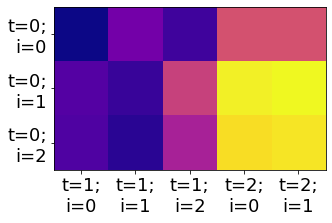

In [15]:
fig, axs = plt.subplots(figsize = (5, 3))
axs.imshow(ex_trans_prob, cmap = 'plasma')
plt.yticks(np.arange(3),["t=0;\ni=0", "t=0;\ni=1", "t=0;\ni=2"], fontsize = 18);
plt.xticks(np.arange(5),["t=1;\ni=0", "t=1;\ni=1", "t=1;\ni=2", "t=2;\ni=0", "t=2;\ni=1"], fontsize = 18);

- We do so for all subsequent spatial coordinates, building directed edges from all coordinates of a given locus to all coordinates of successive loci (defined up to `num_skip` bonds away).
    - Slowly, our adjacency matrix populates with directed edges and weighted accordingly by the bond probability:

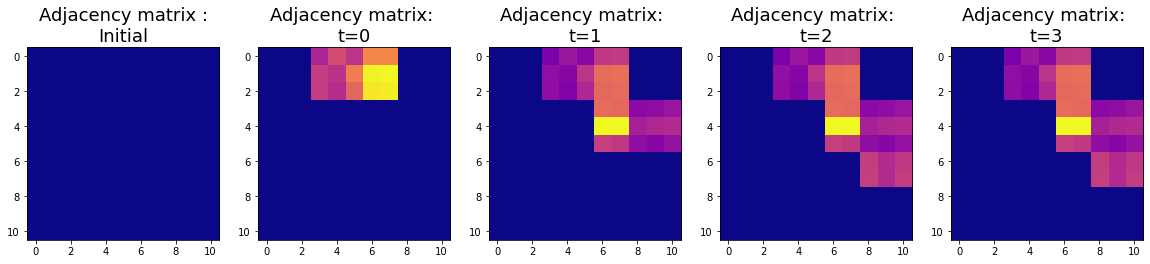

In [16]:
fig, axs = plt.subplots(1, 5, figsize = (20, 5))
for (t, mat), ax in zip(trans_mat_prog.items(), axs.flatten()):
    ax.imshow(mat, cmap = 'plasma')
    if t == -1:
        ax.set_title("Adjacency matrix :\nInitial", fontsize = 18)
    else:
        ax.set_title("Adjacency matrix: \nt={}".format(t), fontsize = 18)

- The reason we consider bond probabilities between non-successive loci (and up to `num_skip` bonds away) is __to acknowledge error__:
    - For instance, it is possible that some spatial coordinates are __inadvertently detected__ for a particular locus (__False Positive__ signal ; ie. off-target hybridization, background fluorescence)
    - At the same time, it is also possible that some spatial coordinates are __never detected__ for a particular locus (__False Negative__ signal ; poor probe hybridization)
        - __THEREFORE__, we must permit the possibility that ___all spatial coordinates___ detected for a particular locus are __noise__ and allowed to be __skipped__:

In [17]:
wg.interact(polymer_skip, Slides=wg.IntSlider(min=1,max=4,step=1, description="Slides : {} /".format(4)));

interactive(children=(IntSlider(value=1, description='Slides : 4 /', max=4, min=1), Output()), _dom_classes=('…

---
- In the demo dataset, we illustrate an example where signals belonging to __t=2__ are seemingly out of place and not congruent with the expected spatial distance:

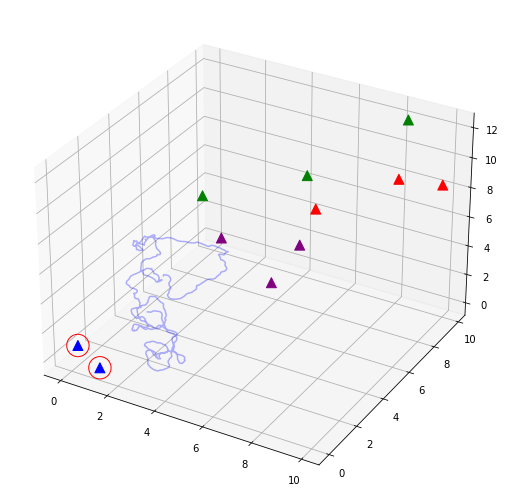

In [18]:
# plot
fig = plt.figure(figsize = (18, 9))
ax = fig.add_subplot(111, projection='3d')

# Draw imaged loci
cdict = {0:'Red', 1:'Green', 2:'Blue', 3:'Purple'}
ax.scatter(df_data.loc[:, 'z_hat'],
           df_data.loc[:, 'y_hat'],
           df_data.loc[:, 'x_hat'],
           c=[cdict[elem] for elem in df_data.t], alpha = 1, marker='^', s = 100)

# Draw fiber
ax.plot(df_fiber.loc[:, 'z_hat'], df_fiber.loc[:, 'y_hat'], df_fiber.loc[:, 'x_hat'], c='Blue', alpha = 0.3, label = 'DNA (unobserved)')

# Draw true positive (true location)
ax.scatter(df_data.loc[[15005, 15006], 'z_hat'],
            df_data.loc[[15005, 15006], 'y_hat'],
            df_data.loc[[15005, 15006], 'x_hat'],
            alpha = 1, marker='o', s = 500, facecolors='none', edgecolors='r')

- In fact, this is reflected in the bond probabilities. If we evaluate the bond probabilities between every spatial candidate for `t=1` to `t=2` and `t=3`, we see that it would be more favourable for us to skip `t=2` and connect directly between `t=1` to `t=3`:

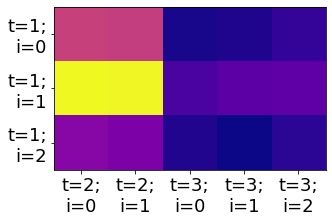

In [19]:
fig, axs = plt.subplots(figsize = (5, 3))
axs.imshow(ex_trans_prob_skip, cmap = 'plasma')
plt.yticks(np.arange(3),["t=1;\ni=0", "t=1;\ni=1", "t=1;\ni=2"], fontsize = 18);
plt.xticks(np.arange(5),["t=2;\ni=0", "t=2;\ni=1", "t=3;\ni=0", "t=3;\ni=1", "t=3;\ni=2"], fontsize = 18);

- The bond probabilities skipping `t=2` (`t=1` --> `t-3`) will incur a penalty, but this is still more favourable than linking any coordinate between `t=1`--> `t=2`:

In [20]:
np.around(ex_trans_prob_skip, decimals = 1)

array([[15.5, 15.2,  7.1,  7.4,  8.1],
       [24.7, 24.6,  9.1,  9.8,  9.9],
       [11.8, 11.3,  7.4,  6.9,  7.8]])

- So what if the starting locus is error prone (ie. all of the spatial coordinates belonging to the starting locus `t=0` are noise and need to be skipped)? 
- Likewise, what if the ending locus is error prone?
    - We create a __single source__ that connects to spatial coordinates belonging to the first `num_skip` loci.
    - We create a __single sink__ that connects to spatial coordinates belonging to the last `num_skip` loci.
        - We create a "pseudo"-bond that incurs a cost of traveling a bond commensurate wtih the number of bonds skipped.
            - This allows us to accomodate skipping the first and last few loci.
            - We achieve this by "padding" the adjacency matrix to create an extra row for the source, and extra column for the sink.
                - We populate "pseudo" bond probabilities using the function `jie.aligner.boundary_init`

In [21]:
# calculate initial and terminal gap penalties
trans_mat_pad = boundary_init(trans_mat=trans_mat,
                              loci_dist=loci_dist, 
                              l_p_bp=l_p_bp,
                              corr_fac=corr_fac,
                              n_colours=n_colours,
                              cell_pts=cell_pts,
                              exp_stretch=exp_stretch,
                              stretch_factor=stretch_factor,
                              lim_init_skip=lim_init_skip,
                              init_skip=init_skip,
                              end_skip=end_skip)

Text(0.5, 1.0, 'After adding source, sink : \nadj matrix shape (13, 13)')

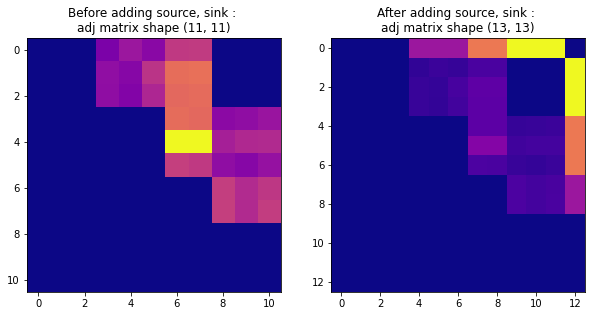

In [22]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

axs[0].imshow(trans_mat, cmap = 'plasma')
axs[0].set_title("Before adding source, sink : \nadj matrix shape {}".format(trans_mat.shape))
axs[1].imshow(trans_mat_pad, cmap = 'plasma')
axs[1].set_title("After adding source, sink : \nadj matrix shape {}".format(trans_mat_pad.shape))

- There is no penalty incurred by entering from source to any of the spatial coordinates belonging to the first locus `t=0`.
- Similarly, there is no penalty incurred by exiting from any of the spatial coordinates belonging to the last locus `t=3` to the sink.

---

- With this adjacency matrix, we create a graph. 
    - We initialize the source and the sink (aka target). We seek to find the shortest graph traversal from source to sink.

In [23]:
wg.interact(find_polymer, Slides=wg.IntSlider(min=1,max=4,step=1, description="Slides : {} /".format(4)));

interactive(children=(IntSlider(value=1, description='Slides : 4 /', max=4, min=1), Output()), _dom_classes=('…

In [24]:
# create discrete state space model
G = igraph.Graph.Adjacency((trans_mat_pad > 0).tolist())

# add edge weights
G.es['weight'] = trans_mat_pad[trans_mat_pad.nonzero()]


# find shortest path (Dijkstra)
shortest_path_length = G.shortest_paths(source = 0, 
                                        target = trans_mat_pad.shape[0]-1, 
                                        weights = 'weight')[0][0]
## NB: path is written in index of FUTURE cell_pts dataframe (subsetted after iterative subtraction)
shortest_path = [elem-1 for elem in G.get_shortest_paths(0, to = trans_mat_pad.shape[0]-1, 
                                                         weights = 'weight')[0][1:-1]]

- The path reflects the selected coordinates from the input that belong to the most likely polymer:

In [25]:
cell_pts_input.iloc[shortest_path]

,x_hat,y_hat,z_hat,Annot,hyb,i,bp,sig_x,sig_y,sig_z
0,7.121910,7.182445,6.081194,TP,0,0,0,1,1,1
5000,8.345561,8.037631,5.236670,TP,1,0,5000,1,1,1
15000,5.277496,6.326657,5.903535,TP,3,0,15000,1,1,1
